### IMPORTS  FOR SKLEARN MODEL AND NLP LIBRARIES

In [28]:
import os
import numpy as np
import pandas as pd
import random
import statistics
import timeit
import itertools
from apyori import apriori
import pickle
from tools import tokenizer, clean_text
import re
import string
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from textblob import TextBlob
from nltk.parse.stanford import StanfordDependencyParser
from nltk.parse.corenlp import CoreNLPDependencyParser
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, log_loss, recall_score,plot_precision_recall_curve
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
    f1_score
from config import DATABASE_FOLDER, DATABASE_FILE, FILE_JAR, FILE_MODELS_JAR
import warnings
warnings.filterwarnings("ignore")

### LOADING AND CLEANING DATASET 

In [29]:
warnings.filterwarnings("ignore")
java_path = "C:/Program Files/Java/jdk1.8.0_161/bin/java.exe"
os.environ['JAVAHOME'] = java_path
coreNLP_path = "./stanford-corenlp-3.9.2.jar"
os.environ["CORENLP_HOME"] = coreNLP_path

if __name__ == '__main__':
    # Testing ...
    pass

TARGET           = ["Sentiment_positive"]
#TARGET           = ["Sentiment_positive"]
FEATURES         = list()
EXPLICIT_ASPECTS = set()
IMPLICIT_ASPECTS = set()

DATASET = DATABASE_FOLDER + DATABASE_FILE
data = pd.read_csv("fb_sentiment.csv")

In [30]:
def clean_text(text: str, stem = True) -> str:
    """Clear text."""

    text = re.sub(r"\W", " ", str(text))

    # Remove all single characters.
    text = re.sub(r"\s+[a-zA-Z]\s+", " ", text)

    # Remove single characters from the start.
    text = re.sub(r"\^[a-zA-Z]\s+", " ", text) 

    # Substituting multiple spaces with single space.
    text = re.sub(r"\s+", " ", text, flags = re.I)

    # Removing prefixed "b"
    text = re.sub(r"^b\s+", "", text)

    # Converting to lowercase.
    text = text.lower()

    # Remove punctuation marks.
    for ch in string.punctuation:
        text = text.replace(ch, "")

    # Remove stopwords.
    text = [word for word in text.split() 
            if word not in stopwords.words("english")]
    text = " ".join(text)
    
    # Lemmatization.
    if stem:
        stemmer = WordNetLemmatizer()
        text    = text.split()
        text    = [stemmer.lemmatize(word) for word in text]
        text    = " ".join(text)

    return text


def tokenizer(text, stem = True):
    """Tokenize text."""

    text   = clean_text(text, stem)
    tokens = word_tokenize(text)

    return tokens

### UTILITY FUNCTIONS FOR ASPECTS EXTRACTION

In [31]:
# Print iterations progress
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '█', printEnd = "\r"):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
        printEnd    - Optional  : end character (e.g. "\r", "\r\n") (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end = printEnd)
    # Print New Line on Complete
    if iteration == total: 
        print()
def FB_text(data):
    """Object generator from dataset text.
    """
    rows = data.shape[0]
    for row in range(rows):
        yield data.loc[row, "Text"]


def update_aspect(data, aspect, row, sentiment):
    """Update an aspect on data to sentiment.
    """
    if aspect not in data.columns:
        data[aspect] = 0.0
    data.loc[row, aspect] = sentiment


def get_sentiment(FB_text: str) -> float:
    """Returns the sentiment of an aspect.
    """
    obj       = TextBlob(FB_text)
    sentiment = obj.sentiment.polarity
    return sentiment


def impute_explicit_aspects(data):
    explicit_aspects = set()
    transactions = list()

    for tweet in FB_text(data):
        transactions.append(tokenizer(text))
        '''
        f = open('tokens-1', 'wb')
        pickle.dump(transactions, f)
        f.close()
        '''

    # print("Printing dataset.............!!!!!!")
    # print(transactions[0:20])

    association_rules = apriori(transactions, min_support=0.1)
    unique_topics = data['Topic'].unique()

    print("Printing association rules......!!!!")
    print("Looping over!")
    for item in association_rules:
        pair = list(item[0])
        for aspect in pair:
            if aspect in unique_topics:
                explicit_aspects.add(aspect)

    print(explicit_aspects)
    # explicit_aspects -= set(["co", "http", "rt"])
    # print(explicit_aspects)

    rows = data.shape[0]
    for row in range(rows):
        textt_tokens = tokenizer(data.loc[row, "Text"])
        for aspect in explicit_aspects:
            if aspect in text_tokens:
                tweet_text = " ".join(FB_tokens)
                sentiment = get_sentiment(FB_text)
                update_aspect(data, aspect, row, sentiment)

    return explicit_aspects


def impute_implicit_aspects(data):
    """Imputes implicit aspects of the dataset.
    """
    implicit_aspects = set()

    parser = CoreNLPDependencyParser(url='http://localhost:9000')

    rows = data.shape[0]
    for row in range(rows):
        printProgressBar(row,rows)
        text   = data.loc[row, "Text"]
        results = parser.raw_parse(text)
        words   = next(results).triples()
        aspects = set()
        for word_1, _, word_2 in words:
            aspects.add(word_1[0])
            aspects.add(word_2[0])
        aspect     = " ".join(aspects)
        aspect     = clean_text(aspect)
        implicit_aspects.add(aspect)
        sentiment  = get_sentiment(aspect)
        update_aspect(data, aspect, row, sentiment)

    return implicit_aspects


def data_preprocessing(data):
    """Data pre-processing: nominal variables to numbers (Topic and Sentiment)
    and elimination of string variables (Text)
    """

    topics     = pd.get_dummies(data["Topic"],  prefix = "Topic",drop_first = True)
    sentiments = pd.get_dummies(data["Sentiment"],  prefix = "Sentiment",drop_first = True)
    data       = data.drop(["Topic", "Sentiment", "TweetText"], axis = 1)

    data       = pd.concat([topics, sentiments, data], axis = 1)

    return data

def impute_overall_sentiment(data):
    """Calculates and imputes the overall sentiment index of the text
    according to aspects.
    """
  
    data["overall_sentiment"] = pd.np.nan
    #print(list(data.columns))
    aspects                   = EXPLICIT_ASPECTS | IMPLICIT_ASPECTS
    rows                      = data.shape[0]
    
    for row in range(rows):
        print(rows)
        print(float(row/rows))
        sentiments = list()
        sentiments.append(random.choice([float(data.loc[row, TARGET]), 1]))
        for aspect in aspects:
            sentiments.append(data.loc[row, aspect])

        data.loc[row, "overall_sentiment"] = statistics.mean(sentiments)

    return data


### CALCULATING IMPLICIT AND EXPLICIT ASPECTS

In [32]:
if __name__ == '__main__':
    print("")
    print(__doc__, end = "\n")
    print("* Calculating the explicit aspects of Text using the Apriori Algorithm ...")
    EXPLICIT_ASPECTS = impute_explicit_aspects(data)
    print("* The explicit aspects obtained from this dataset are:", EXPLICIT_ASPECTS)

    print("* Calculating the Implicit Aspects of Text Using the SDP Algorithm ...")
    IMPLICIT_ASPECTS = impute_implicit_aspects(data)
    # print("* The implicit aspects obtained are:", IMPLICIT_ASPECTS)
    print("* Pre-processing the data before feature selection ...")
    data             = data_preprocessing(data)
    print("*Imputing overall sentiment metrics to tweets ...")
    data             = impute_overall_sentiment(data)


Automatically created module for IPython interactive environment
* Calculating the explicit aspects of tweets using the Apriori Algorithm ...
Printing association rules......!!!!
Looping over!
set()
* The explicit aspects obtained from this dataset are: set()
* Calculating the Implicit Aspects of Tweets Using the SDP Algorithm ...
* Pre-processing the data before feature selection ...███████████████████████████████████████████████-| 99.9% 
*Imputing overall sentiment metrics to tweets ...
1000
0.0
1000
0.001
1000
0.002
1000
0.003
1000
0.004
1000
0.005
1000
0.006
1000
0.007
1000
0.008
1000
0.009
1000
0.01
1000
0.011
1000
0.012
1000
0.013
1000
0.014
1000
0.015
1000
0.016
1000
0.017
1000
0.018
1000
0.019
1000
0.02
1000
0.021
1000
0.022
1000
0.023
1000
0.024
1000
0.025
1000
0.026
1000
0.027
1000
0.028
1000
0.029
1000
0.03
1000
0.031
1000
0.032
1000
0.033
1000
0.034
1000
0.035
1000
0.036
1000
0.037
1000
0.038
1000
0.039
1000
0.04
1000
0.041
1000
0.042
1000
0.043
1000
0.044
1000
0.045
1000


In [33]:
EXPLICIT_ASPECTS

set()

In [34]:
IMPLICIT_ASPECTS

{'',
 '1 3 want',
 '1 99 russian even spelling school bought send bible pray cant bible condom',
 '10 anybody 5 chapter summary jump read kindle toc patterson deal page tick text big thank free chapter real tell',
 '10 awesome took day kindle cruise',
 '10 bet sleeve cost 1 le fabric 24 99 make',
 '10 hold held refused one year love unless good two kindle book cant baby person sleep kid fussy',
 '10 sweet downloaded book wow free',
 '2 glad kindle timbuk',
 '2nd getting one new generation thinking thought',
 '2nd right kindle generation original',
 '3 1 right press new go see version operating bottom screen number 3 0 2 read something janice select menu button home like xxxxxxx o system kindle system',
 '3 definitely cat meow kindle',
 '3 feature',
 '3 kindle',
 '3 kindle love',
 '3 thank kindle santa',
 '30 20 much think',
 '3g agree love kindle',
 '3g kindle new love',
 '3g transferred got capability second kindle book love size smaller effortlessly',
 '5 hilite collection melodie di

In [35]:
len(EXPLICIT_ASPECTS | IMPLICIT_ASPECTS)

913

In [36]:
data

,Topic_United State,Topic_amazon,Topic_nil,Sentiment_O,Sentiment_P,Sentiment_negative,Sentiment_neutral,Sentiment_positive,http www amazon com circumstantial evidence getting florida bozarth ebook dp b004fpz452 ref pdrhfpt1 attorney state know ypur murder senator runner drug something today copy get,indian sled ice man dog island story ghost woman here french across transporting mackinac american read cheboygan ghost add single round century kindle 19th,...,kindles holding people id dangerously nice call cringed around balancing leaping fence bit living,kindle heart,drained hardly even battery reading around 8 3 hour yesterday kindle,kindle3 available cover buy waiting wi light love dx fi,well commercial better soooo much done,youth appeal widen oriented think liked,border format commercial publisher even different point store closing people ebook whether book struggling best future like many opinion life kindle think platform,happier great mine product 3 could kindle,easily share drawback love develop kindle book cant way hate big,overall_sentiment
0,1,0,0,0,0,0,1,0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.001094
1,0,0,0,0,0,0,1,0,0.0,-0.067857,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,-0.000074
2,0,1,0,0,0,0,1,0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000
3,0,0,0,0,0,0,1,0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000875
4,0,0,0,0,0,1,0,0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000109
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,1,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.6,0.0,0.0,0.000000,0.001751
996,0,0,0,0,0,0,0,1,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.3,0.0,0.000000,0.001422
997,0,0,0,0,0,0,0,1,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.8,0.000000,0.001969
998,0,0,0,0,0,1,0,0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033333,0.000036


### Sentiment Analyzer

In [37]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()
# function to calculate vader sentiment
def vadersentimentanalysis(overall_sentiment):
    vs = analyzer.polarity_scores(overall_sentiment)
    return vs['positive']
    data['Vader Sentiment'] = data['overall_sentiment'].apply(vadersentimentanalysis)

### Feature Selection

In [38]:
# Import the Kernel PCA 
from sklearn.decomposition import KernelPCA
FEATURES    = list(set(data.columns) - set(TARGET))
# initialize the Kernel PCA object
kpca    = KernelPCA(n_components = 2, kernel= "rbf")# extracts 2 features, specify the kernel as rbf
X       = StandardScaler().fit_transform(data)
principal_components  = kpca.fit_transform(X)
kpca_data             = pd.DataFrame(data =  principal_components ,columns = ["Principal Component1","Principal Component2"])
kpca_data             = pd.concat([kpca_data, data[TARGET]], axis = 1)


In [39]:
kpca_data

,Principal Component1,Principal Component2,Sentiment_positive
0,-0.182826,-0.023711,0
1,-0.182870,-0.040654,0
2,0.240726,-0.087887,0
3,-0.182650,-0.026902,0
4,-0.191618,-0.025943,0
...,...,...,...
995,-0.183801,0.022784,1
996,-0.183190,0.018011,1
997,-0.184313,0.025950,1
998,-0.191676,-0.026972,0


In [45]:
#confusion matrix plot function
def cm_plot(var):
    plt.figure(figsize=(15,5))
    plt.clf()
    plt.imshow(var, interpolation='nearest', cmap='tab20')
    classNames = ['Incorrectly Classified','Correctly Classified']
    plt.title('Confusion Matrix')
    plt.ylabel('Actual\n')
    plt.xlabel('Predicted\n')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+"="+str(var[i][j]),horizontalalignment='center' 
                     )
    plt.show()

In [46]:
from sklearn.model_selection import train_test_split

In [47]:
 #Training and testing split
x_train1, X_test, y_train1, y_test = train_test_split(X, y,test_size=0.2, random_state=0)

In [48]:
models = []
models.append(('MLP', MLPClassifier(activation = 'tanh',alpha=1,max_iter=1000)))
models.append(('SVM', SVC(probability=True)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('DT', DecisionTreeClassifier(max_depth=5)))
models.append(('NB', GaussianNB()))
models.append(('xgb', XGBClassifier(random_state=0, learning_rate =0.01,n_estimators=100)))





MLPClassifier Results:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Accuracy: 77.0000%


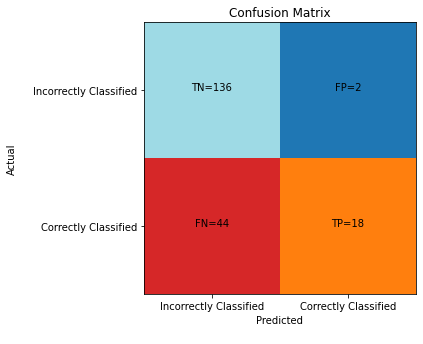





SVC Results:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Accuracy: 94.0000%


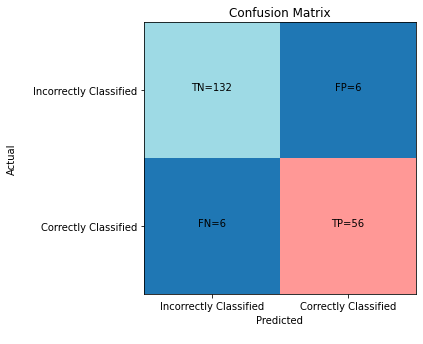





KNeighborsClassifier Results:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Accuracy: 97.5000%


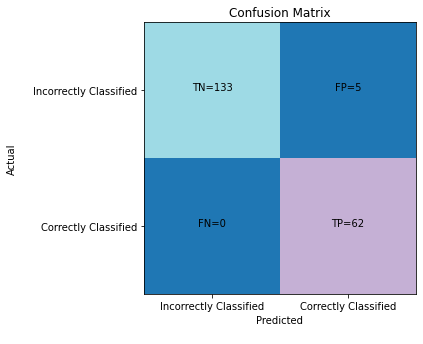





DecisionTreeClassifier Results:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Accuracy: 99.0000%


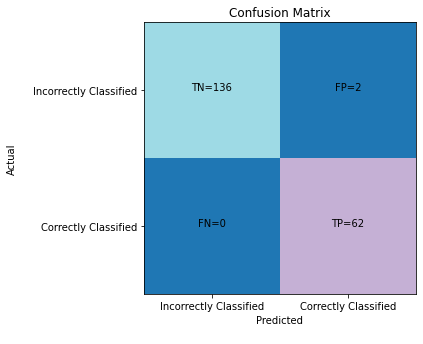





GaussianNB Results:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Accuracy: 78.0000%


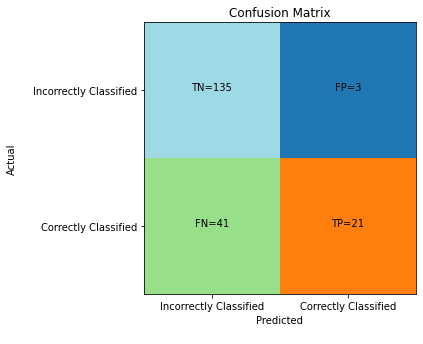

[15:24:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.




XGBClassifier Results:
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Accuracy: 98.0000%


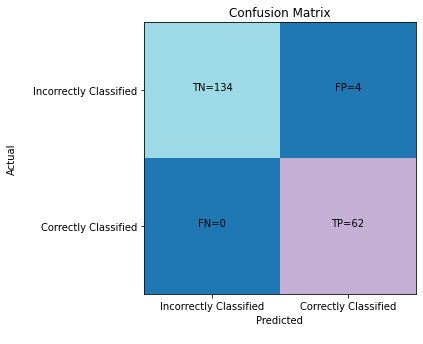

****************************************


In [49]:
  #putting results in df
res_cols=["Classifier", "Accuracy", "Recall", "F1","Precision","Execution Time"]
results = pd.DataFrame(columns=res_cols)

for name, model in models:
    model.fit(x_train1, y_train1)
    name = model.__class__.__name__
    y_pred = model.predict(X_test)

    print("\n"*3)
    print(name,"Results:")
       
    print('~'*40)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print("Accuracy: {:.4%}".format(acc))
    

    start_time = timeit.default_timer()
    cm = confusion_matrix(y_test, y_pred)
    
    cm_plot(cm)
    
    rec= recall_score(y_test, y_pred)
    f1s=f1_score(y_test, y_pred)
    pre=precision_score(y_test, y_pred)
    results_final = pd.DataFrame([[name, round(acc*100,2), 
                                    round(rec*100,2),
                                   round(f1s*100,2),round(pre*100,2),format(timeit.default_timer() - start_time)]],
                                 columns=res_cols)
    results = results.append(results_final)
    
print("*"*40)

In [50]:
results.head(20)

,Classifier,Accuracy,Recall,F1,Precision,Execution Time
0,MLPClassifier,77.0,29.03,43.90,90.00,0.4233833999999206
0,SVC,94.0,90.32,90.32,90.32,0.15766260000009424
0,KNeighborsClassifier,97.5,100.00,96.12,92.54,0.2112449999999626
0,DecisionTreeClassifier,99.0,100.00,98.41,96.88,0.16258700000003046
0,GaussianNB,78.0,33.87,48.84,87.50,0.1545366999998805
0,XGBClassifier,98.0,100.00,96.88,93.94,0.17355889999998908


In [51]:
import sklearn.metrics
import sklearn.metrics as metrics

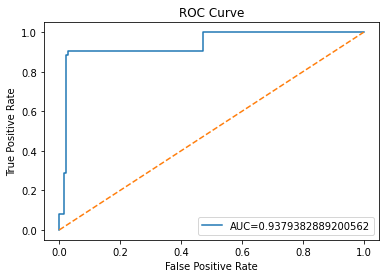

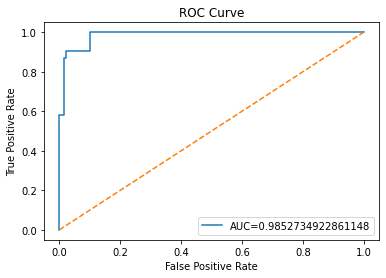

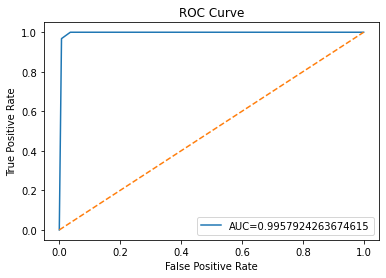

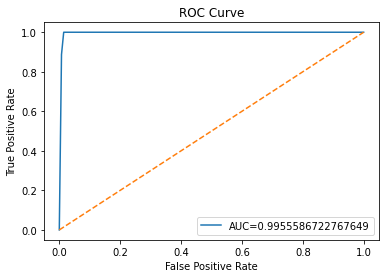

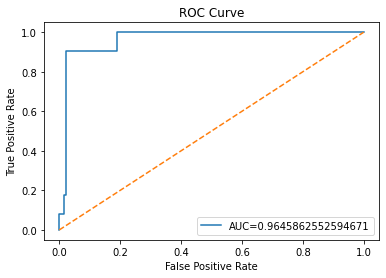

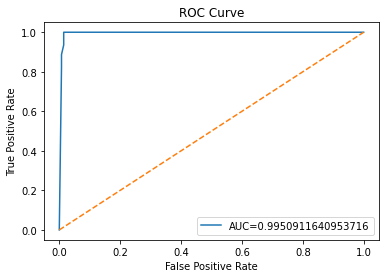

In [52]:
for name,model in models:
#define metrics
    y_pred_proba = model.predict_proba(X_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
#create ROC curve
    plt.title('ROC Curve')
    plt.plot(fpr,tpr,label="AUC="+str(auc))
    plt.plot([0, 1], ls="--")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend()
    plt.show()

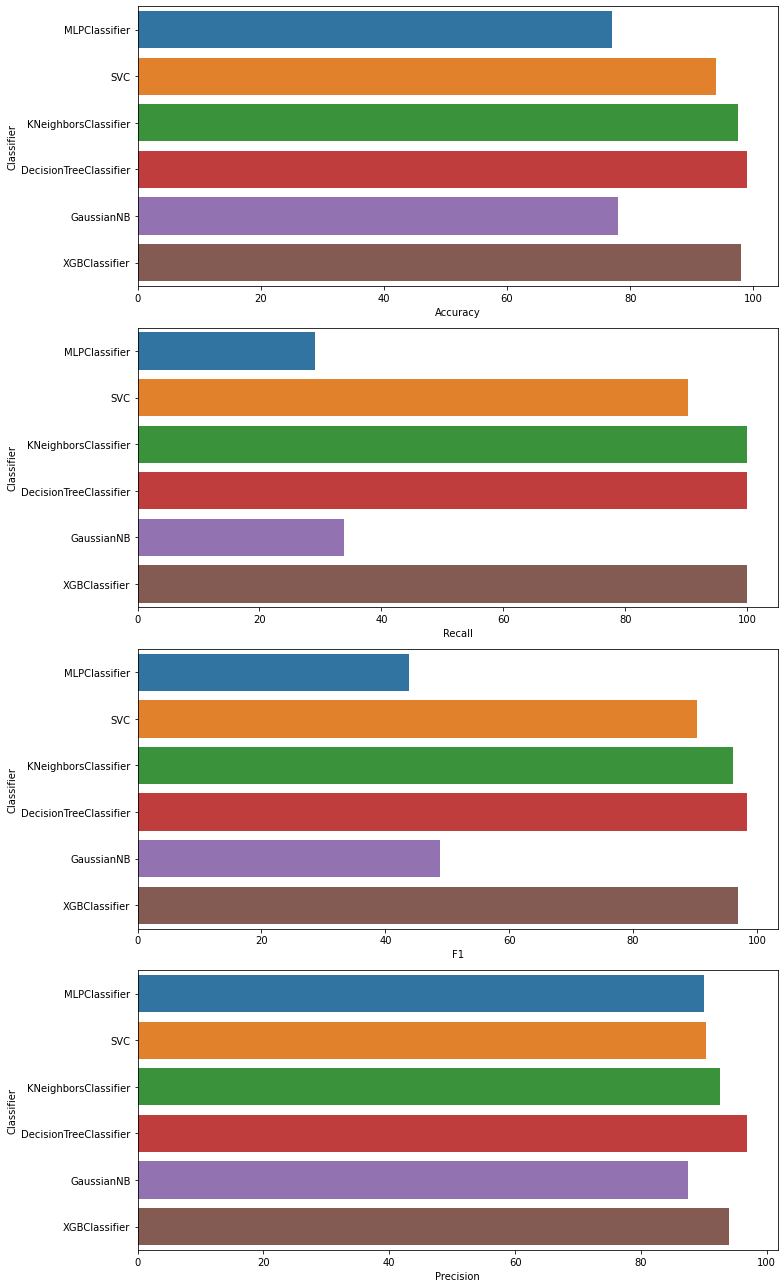

In [53]:
#Visualize scores for all model
fig, ax =plt.subplots(nrows=4, ncols=1, figsize = (11,18))
sns.barplot(x='Accuracy', y='Classifier', data=results, ax=ax[0])
sns.barplot(x='Recall', y='Classifier', data=results, ax=ax[1])
sns.barplot(x='F1', y='Classifier', data=results, ax=ax[2])
sns.barplot(x='Precision', y='Classifier', data=results, ax=ax[3])
plt.tight_layout()
plt.show()